In [1]:
%load_ext autoreload
%autoreload 2

from base64 import b64encode
import copy
from datetime import datetime
import getopt
import io
from io import BytesIO
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

module_path = os.path.abspath(os.path.join('../lddecode'))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lddecode.utils import *
import lddecode.core as core

# Notebook-only functions go here

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

matplotlib.rc('figure', figsize=(20, 12))

In [270]:
#filename = '/home/cpage/lddecode.comb/superdon8071.lds'
filename = '/home/cpage/ld-decode-testdata/ve-snw-cut.lds'
outname = 'devbook'
system = 'NTSC'
foutput = False
loader = make_loader(filename)

firstframe = 0
req_frames = 3

ldd = core.LDdecode(filename, outname, loader, system=system)
ldd.roughseek(firstframe * 2)
ldd.blackIRE = 7.5

fields = []
for i in range(0, req_frames * 2):
    fields.append(ldd.readfield())
    

file frame 1 CAV frame 30250
file frame 2 CAV frame 30251


In [271]:
def drawImage(rgb):
    im = Image.fromarray(rgb)

    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [288]:
class CombNTSC:
    ''' *partial* NTSC comb filter class - only enough to do VITS calculations ATM '''
    
    def __init__(self, field):
        self.field = field
        self.cbuffer1D = self.split1D()
        self.cbuffer2D = self.split2D()

    def getlinephase(self, line):
        ''' determine if a line has positive color burst phase '''
        fieldID = self.field.fieldPhaseID
        
        fieldPositivePhase = (fieldID == 1) | (fieldID == 4)
        
        return fieldPositivePhase if ((line % 2) == 0) else not fieldPositivePhase

    def split1D(self, subset = None):
        ''' 
        prev_field: Compute values for previous field
        subset: a slice computed by lineslice_tbc (default: whole field) 
        
        NOTE:  first and last two returned values will be zero, so slice accordingly
        '''
        
        data = self.field.dspicture
        
        if subset:
            data = data[subset]
            
        # this is a translation of this code from tools/ld-chroma-decoder/comb.cpp:
        #
        # for (qint32 h = configuration.activeVideoStart; h < configuration.activeVideoEnd; h++) {
        #  qreal tc1 = (((line[h + 2] + line[h - 2]) / 2) - line[h]);
                        
        fldata = data.astype(np.float32)
        cbuffer = np.zeros_like(fldata)
        
        cbuffer[2:-2] = (fldata[:-4] + fldata[4:]) / 2
        cbuffer[2:-2] -= fldata[2:-2]
        
        return cbuffer / 2

    def lsl(self, line):
        return slice(910 * line, 910 * (line + 1))
    
    def split2D(self, first = 10, last = 262):
        adaptive_level = 45
        kfilter = [1.0] # sps.firwin(5, .1)

        blacklevel = fields[0].hz_to_output(ldd.rf.iretohz(0))
        blackline = np.full(910, blacklevel)

        cbuf1D = self.cbuffer1D
        cbuf = np.zeros_like(cbuf1D)

        for l in range(0, 263):
            curline = self.field.dspicture[self.lsl(l)].astype(np.float32)
            if l < first or l > last:
                k = np.zeros(910)
            else:
                if (l - 2) > first:
                    prevline = self.field.dspicture[self.lsl(l - 2)].astype(np.float32)
                    prevcbuf = self.cbuffer1D[self.lsl(l-2)]

                    kp = np.fabs(curline - prevline) #+ np.fabs(np.roll(curline, 1) - np.roll(nextline, 1))
                    kpf = sps.lfilter(kfilter, [1.0], kp)
                    kp_out = np.clip(1 - (kpf / fields[0].out_scale) / adaptive_level, 0, 1)
                else:
                    prevline = blackline
                    kp_out = np.zeros(910)
                    prevcbuf = np.zeros(910)

                if (l + 2) < last:
                    nextline = self.field.dspicture[self.lsl(l + 2)].astype(np.float32)
                    nextcbuf = self.cbuffer1D[self.lsl(l+2)]

                    kn = np.fabs(curline - nextline) #+ np.fabs(np.roll(curline, 1) - np.roll(nextline, 1))
                    knf = sps.lfilter(kfilter, [1.0], kn)
                    kn_out = np.clip(1 - (knf / fields[0].out_scale) / adaptive_level, 0, 1)
                else:
                    nextline = blackline
                    kn_out = np.zeros(910)
                    nextcbuf = np.zeros(910)

                kna = kn_out.copy()
                kna[kp_out > (3 * kn_out)] = 0

                kpa = kp_out.copy()
                kpa[kn_out > (3 * kp_out)] = 0

                k = np.min([kna, kpa], axis = 0)
                kprev = kpa * (k / 2)
                knext = kna * (k / 2)

                c2d = (prevcbuf * kpa / 2) + (nextcbuf * kna / 2)

                cbuf[self.lsl(l)] = (cbuf1D[self.lsl(l)] * (1 - k)) + (c2d * k)

        return cbuf
                
    def splitIQ(self, cbuffer, line = 0):
        linephase = self.getlinephase(line)
        
        si = cbuffer[1::2].copy()
        sq = cbuffer[::2].copy()

        if not linephase:
            si[1::2] = -si[1::2]
            sq[0::2] = -sq[0::2]
        else:
            si[0::2] = -si[0::2]
            sq[1::2] = -sq[1::2]
    
        return si.astype(np.int16), sq.astype(np.int16)
    
    def calcLine19Info(self, comb_field2 = None):
        ''' returns color burst phase (ideally 147 degrees) and (unfiltered!) SNR '''
        
        # Don't need the whole line here, but start at 0 to definitely have an even #
        l19_slice = self.field.lineslice_tbc(19, 0, 40)
        l19_slice_i70 = self.field.lineslice_tbc(19, 14, 18)

        # fail out if there is obviously bad data
        if not ((np.max(self.field.output_to_ire(self.field.dspicture[l19_slice_i70])) < 100) and
                (np.min(self.field.output_to_ire(self.field.dspicture[l19_slice_i70])) > 40)):
            #logging.info("WARNING: line 19 data incorrect")
            #logging.info(np.max(self.field.output_to_ire(self.field.dspicture[l19_slice_i70])), np.min(self.field.output_to_ire(self.field.dspicture[l19_slice_i70])))
            return None, None, None

        cbuffer = self.cbuffer2D[l19_slice]
        if comb_field2 is not None:
            # fail out if there is obviously bad data
            if not ((np.max(self.field.output_to_ire(comb_field2.field.dspicture[l19_slice_i70])) < 100) and
                    (np.min(self.field.output_to_ire(comb_field2.field.dspicture[l19_slice_i70])) > 40)):
                return None, None, None

            cbuffer -= comb_field2.cbuffer[l19_slice]
            cbuffer /= 2
            
        si, sq = self.splitIQ(cbuffer, 19)

        sl = slice(110,230)
        cdata = np.sqrt((si[sl] ** 2.0) + (sq[sl] ** 2.0))

        phase = np.arctan2(np.mean(si[sl]),np.mean(sq[sl]))*180/np.pi
        if phase < 0:
            phase += 360

        # compute SNR
        signal = np.mean(cdata)
        noise = np.std(cdata)

        snr = 20 * np.log10(signal / noise)
        
        return signal / (2 * self.field.out_scale), phase, snr

    # Colorspace conversion
    def YIQtoRGB(self, Y, I, Q, irescale = True):
        R = Y + ( .956 * I) + (.621 * Q)
        G = Y - ( .272 * I) - (.647 * Q)
        B = Y - (1.106 * I) + (1.703 * Q)
        print(R.max())
        
        if irescale == False:
            #return np.clip(R, 0, 65535), np.clip(G, 0, 65535), np.clip(B, 0, 65535)
            return np.clip(R/256, 0, 65535), np.clip(G/256, 0, 65535), np.clip(B/256, 0, 65535)
        else:
            blacklevel = fields[0].hz_to_output(ldd.rf.iretohz(0))
            whitelevel = fields[0].hz_to_output(ldd.rf.iretohz(100))
            
            lrange = whitelevel - blacklevel
            R = ((R - blacklevel) / lrange) * 256
            G = ((G - blacklevel) / lrange) * 256
            B = ((B - blacklevel) / lrange) * 256
            print(R.max())
            
            return np.clip(R, 0, 255), np.clip(G, 0, 255), np.clip(B, 0, 255)

    def toYIQ(self, cbuffer = None):
        if cbuffer is None:
            cbuffer = self.cbuffer2D

        I, Q = self.splitIQ(cbuffer)
        Iout = np.repeat(I, 2)
        Qout = np.repeat(Q, 2)

        pic = self.field.dspicture.copy()

        for l in range(0, 263):
            sl_y = slice(910 * l, 910 * (l + 1))
            sl_c = slice(455 * l, 455 * (l + 1))
            lphase = 1 if self.getlinephase(l) else -1

            adj = np.zeros(910, dtype=np.float)

            adj[::4]  = (Q[sl_c][::2] * lphase)
            adj[1::4] = -(I[sl_c][::2] * lphase)
            adj[2::4] = -(Q[sl_c][1::2] * lphase)
            adj[3::4] = (I[sl_c][1::2] * lphase)
            #adj /= 1

            pic[sl_y] = np.clip(pic[sl_y].astype(float) + adj, 0, 65535)

        return (pic, Iout, Qout)

    def toRGB(self, YIQ):
        RGB = self.YIQtoRGB(*YIQ, True)
        
        rgbArray = np.zeros((263,910,3), 'uint8')
        rgbArray[...,0] = RGB[0].reshape(263,910) 
        rgbArray[...,1] = RGB[1].reshape(263,910) 
        rgbArray[...,2] = RGB[2].reshape(263,910) 

        return rgbArray    

In [305]:
def split2D(self, first = 10, last = 262):
    adaptive_level = 45
    kfilter = [1.0] # sps.firwin(5, .1)

    blacklevel = fields[0].hz_to_output(ldd.rf.iretohz(0))
    blackline = np.full(910, blacklevel)

    cbuf1D = self.cbuffer1D
    cbuf = np.zeros_like(cbuf1D)

    for l in range(0, 263):
        curline = self.field.dspicture[self.lsl(l)].astype(np.float32)
        if l < first or l > last:
            k = np.zeros(910)
        else:
            if (l - 2) > first:
                prevline = self.field.dspicture[self.lsl(l - 2)].astype(np.float32)
                prevcbuf = self.cbuffer1D[self.lsl(l-2)]

                kp = np.fabs(curline - prevline) #+ np.fabs(np.roll(curline, 1) - np.roll(nextline, 1))
                kpf = sps.lfilter(kfilter, [1.0], kp)
                kp_out = np.clip(1 - (kpf / fields[0].out_scale) / adaptive_level, 0, 1)
            else:
                prevline = blackline
                kp_out = np.zeros(910)
                prevcbuf = np.zeros(910)

            if (l + 2) < last:
                nextline = self.field.dspicture[self.lsl(l + 2)].astype(np.float32)
                nextcbuf = self.cbuffer1D[self.lsl(l+2)]

                kn = np.fabs(curline - nextline) #+ np.fabs(np.roll(curline, 1) - np.roll(nextline, 1))
                knf = sps.lfilter(kfilter, [1.0], kn)
                kn_out = np.clip(1 - (knf / fields[0].out_scale) / adaptive_level, 0, 1)
            else:
                nextline = blackline
                kn_out = np.zeros(910)
                nextcbuf = np.zeros(910)

            kna = kn_out.copy()
            kna[kp_out > (3 * kn_out)] = 0

            kpa = kp_out.copy()
            kpa[kn_out > (3 * kp_out)] = 0

            kpa = 1.0
            kna = 0.0
            k = np.min([kna, kpa], axis = 0)
            kprev = kpa * (k / 2)
            knext = kna * (k / 2)

            #c2d = (prevcbuf * kpa / 2) + (nextcbuf * kna / 2)
            c2d = prevcbuf
            k = 0

            cbuf[self.lsl(l)] = (cbuf1D[self.lsl(l)] * (1 - k)) + (c2d * k)

    return cbuf

62644.626000000004
337.7473285714286


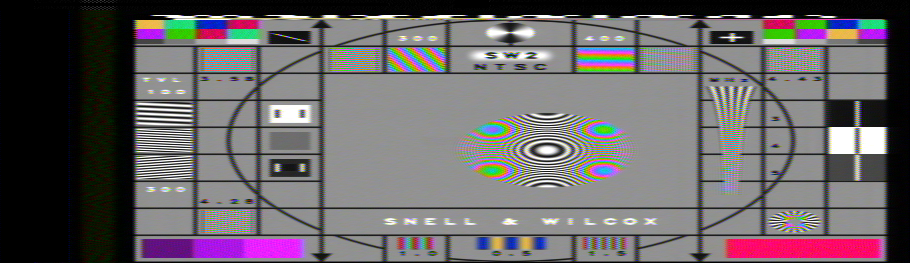

In [306]:
c0 = CombNTSC(fields[0])

cbuf2d = split2D(c0)
YIQ = c0.toYIQ(cbuf2d)
RGB = c0.toRGB(YIQ)

drawImage(RGB)

In [223]:

RGB.mean()

0.15776682126492012

In [211]:
YIQ[2].shape

(239330,)

In [182]:
c0 = CombNTSC(fields[0])
#plt.plot(c0.cbuffer1D[self.lsl(120)])
#plt.plot(c0.cbuffer2D[self.lsl(120)])
#plt.plot(cbufx[self.lsl(120)])


In [183]:
RGB = c0.toRGB()

ValueError: cannot reshape array of size 2730 into shape (263,910)

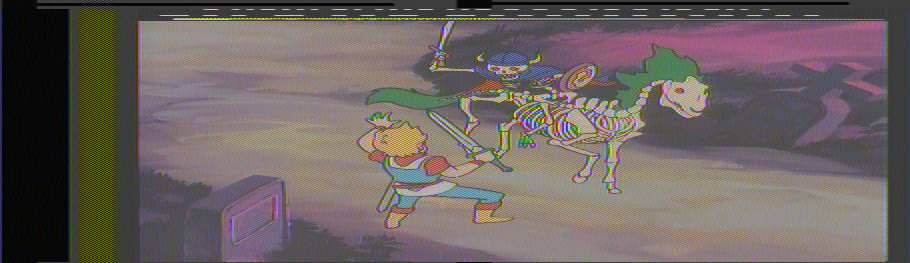

In [171]:
def drawImage(rgb):
    im = Image.fromarray(rgb)

    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())

drawImage(RGB)

In [134]:
239330/910

263.0

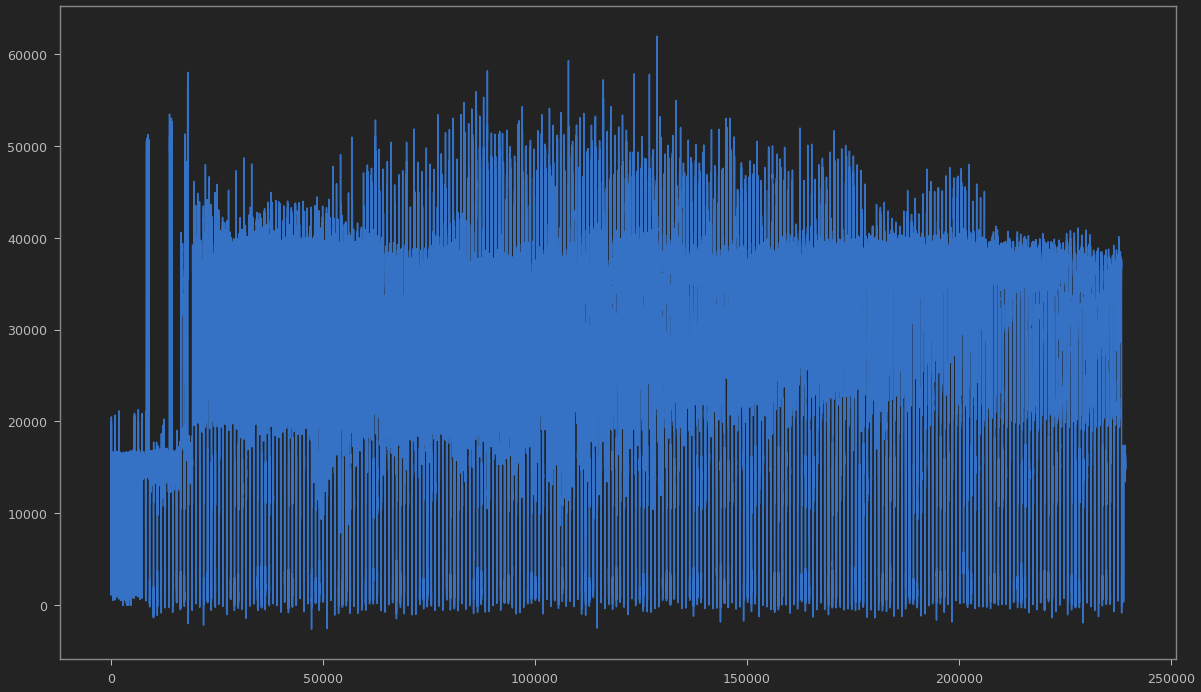

In [125]:
plt.plot(RGB[0])

(237510,)
uint8 (261, 910) (261, 910)


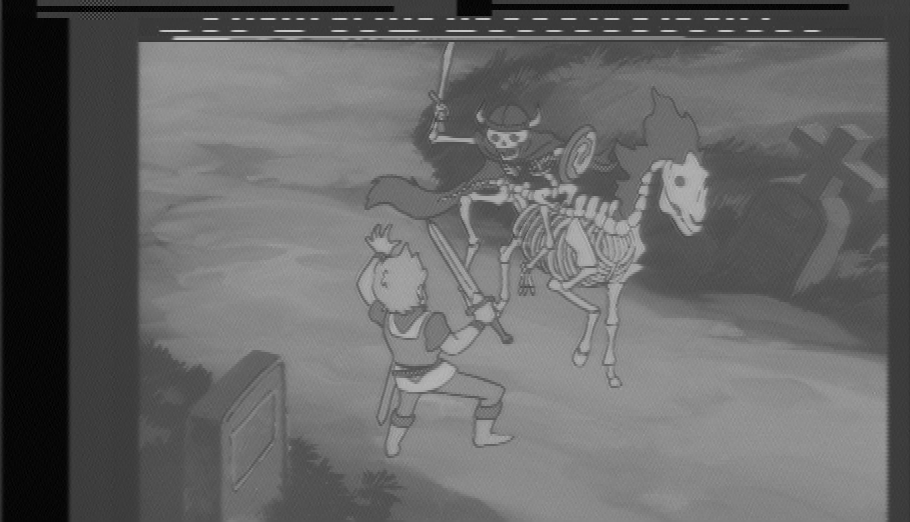

In [118]:
draw_raw_bwimage(pic, 910, 261)

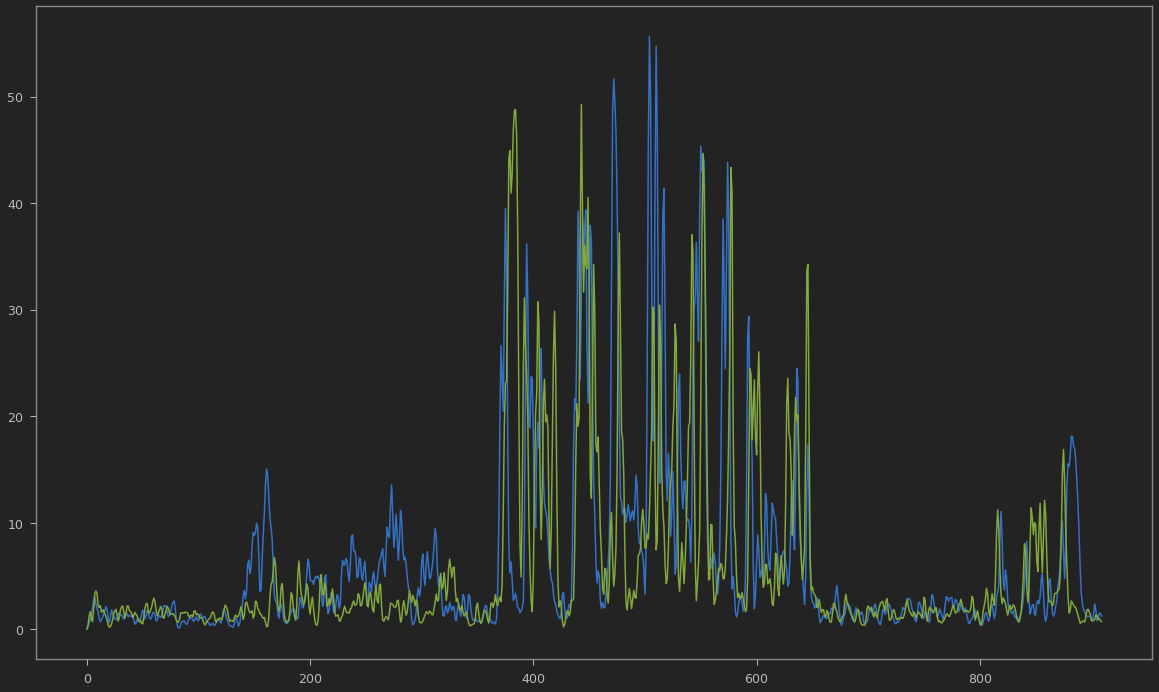

In [14]:

kp = np.fabs(curline - prevline) #+ np.fabs(np.roll(curline, 1) - np.roll(nextline, 1))
kpf = sps.lfilter(kfilter, [1.0], kp)

kn = np.fabs(curline - nextline) #+ np.fabs(np.roll(curline, 1) - np.roll(nextline, 1))
knf = sps.lfilter(kfilter, [1.0], kn)

scaler = fields[0].out_scale
plt.plot(kpf / scaler)
plt.plot(knf / scaler)

In [13]:
scaler

12142.857142857143

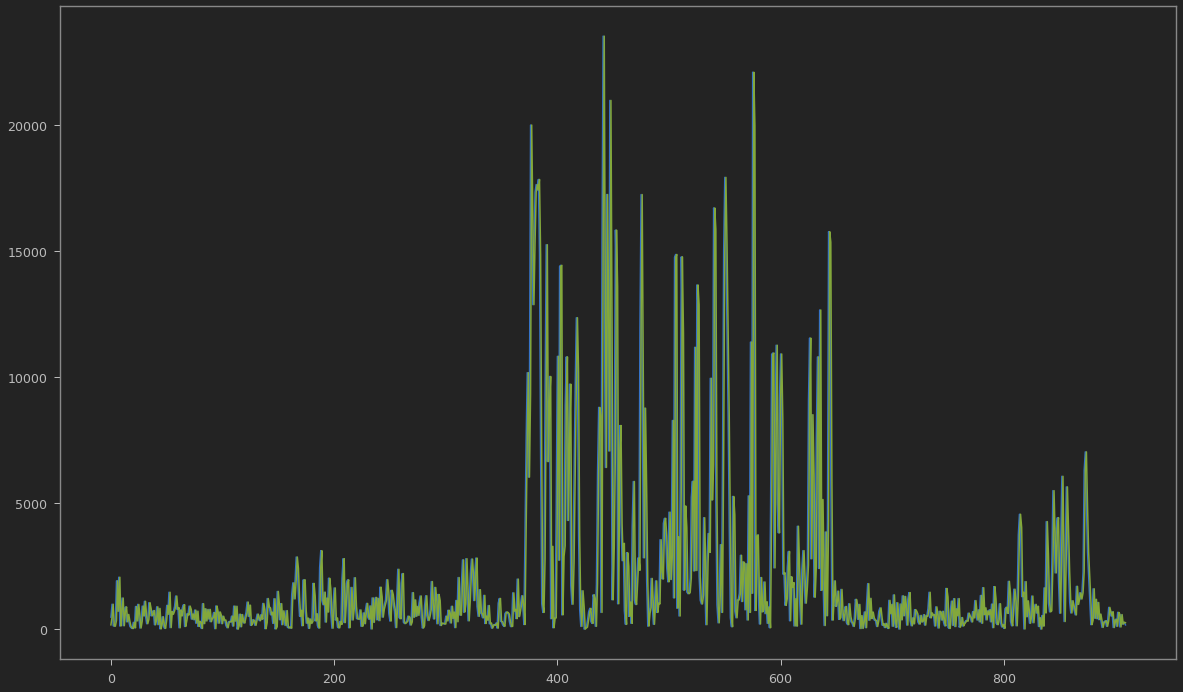

In [294]:
plt.plot(np.fabs(np.roll(curline, 0) - np.roll(nextline, 0)))
plt.plot(np.fabs(np.roll(curline, 1) - np.roll(nextline, 1)))

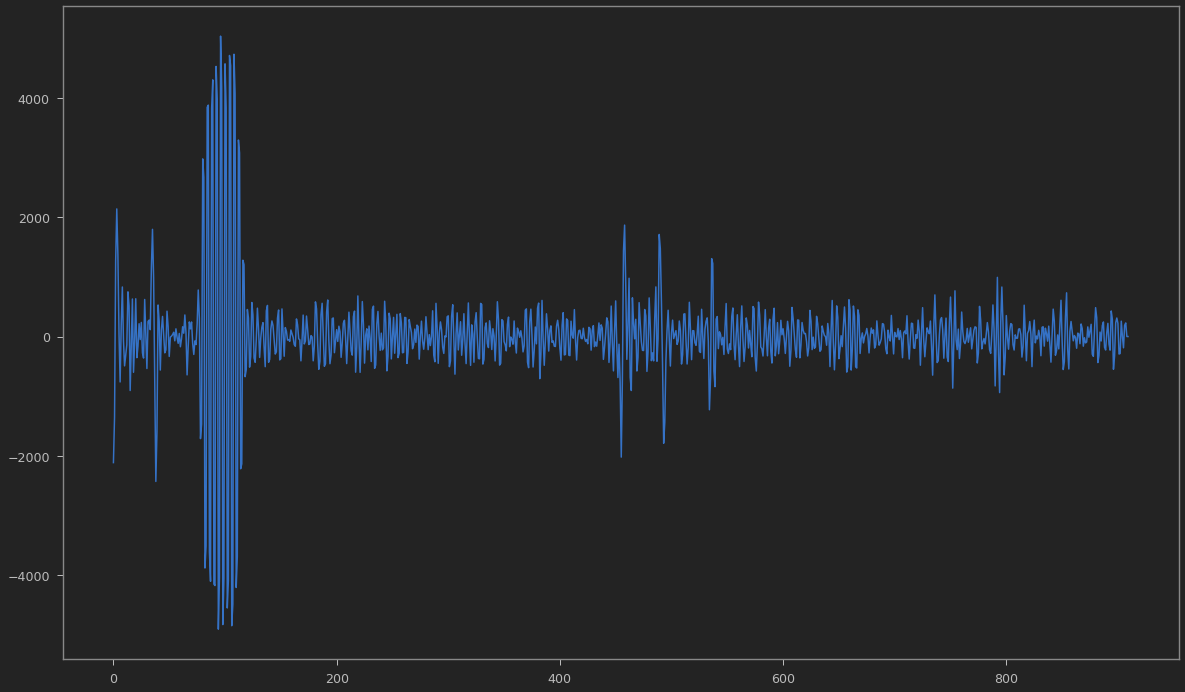

In [263]:
plt.plot(adj)

(237510,)
uint8 (261, 910) (261, 910)


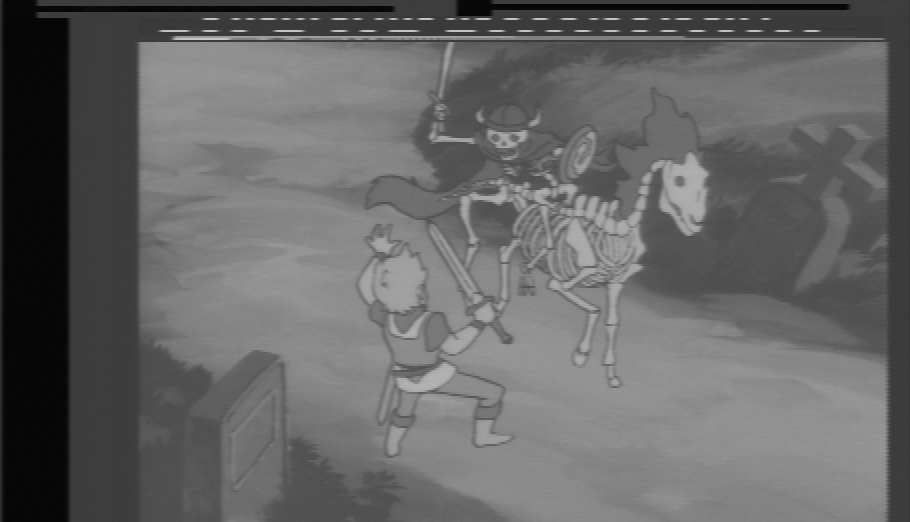

In [51]:
opic = c0.field.dspicture.copy()
draw_raw_bwimage(pic, 910, 261)

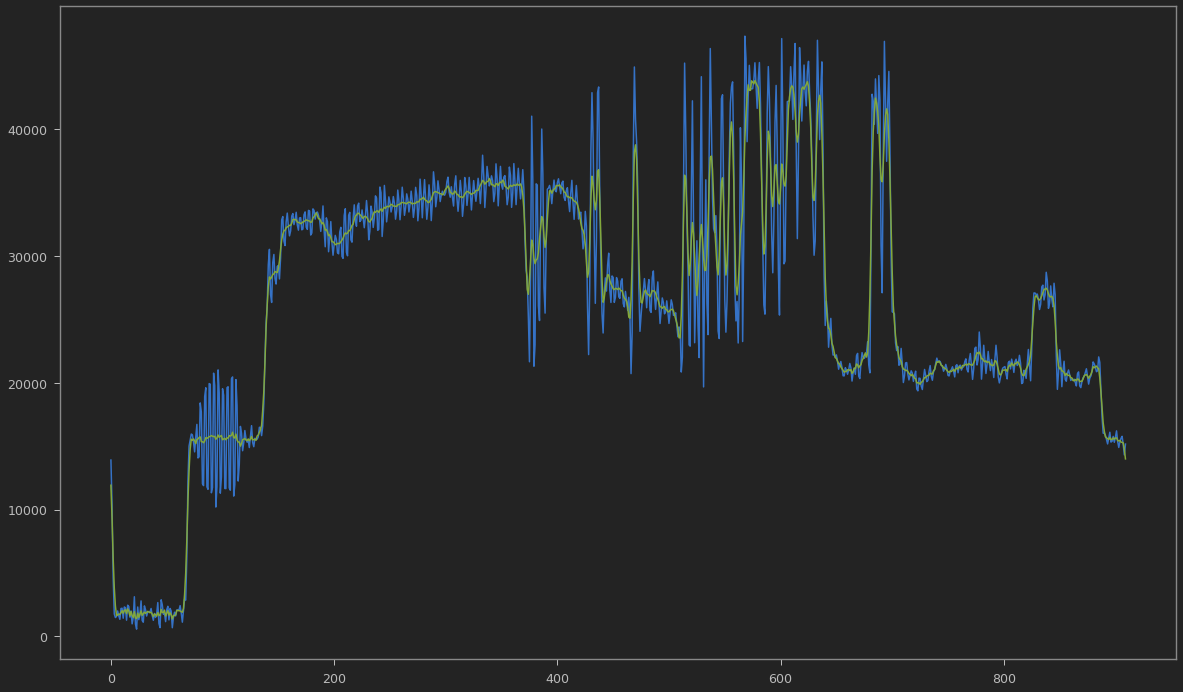

In [269]:
l = 115
plt.plot(opic[910 * l: 910 * (l + 1)])
plt.plot(pic[910 * l: 910 * (l + 1)])


In [179]:
adj.shape

()

In [160]:
I[::2].astype(np.int16)

array([    0, -1148, -2320, ...,   844,   135,     0], dtype=int16)

In [164]:
pic[sl][::4]

array([13798,   843,   723,  1121,   413,   612,  1410,  1281,  1207,
       14634, 15346, 15903, 16135, 15801, 15423, 15157, 15492, 15672,
       15164, 17752, 18863, 20427, 21091, 21483, 20831, 21326, 21588,
       20538, 18627, 16205, 15800, 15359, 15186, 15230, 15376, 15625,
       15458, 15360, 15593, 15502, 15382, 15758, 15784, 15934, 15467,
       15275, 15569, 15296, 15784, 15617, 15373, 15371, 15119, 15246,
       15414, 15156, 15201, 15838, 15563, 14775, 15706, 15065, 15419,
       15572, 15118, 15247, 15179, 15374, 15804, 15631, 15188, 15326,
       15130, 15000, 15300, 15541, 15533, 15537, 15760, 15463, 15508,
       15394, 15439, 15474, 16222, 15576, 15467, 15548, 14809, 15025,
       15533, 15144, 15261, 15099, 15689, 15155, 15416, 15270, 15263,
       15732, 15702, 15794, 14857, 14980, 15268, 15585, 15487, 15330,
       15439, 15975, 15524, 15565, 15910, 15145,  9568,  1616,  1173,
        1319,   848,   405,  1461,  1222,  3678, 14590, 14696, 15583,
       15486, 15393,

In [150]:
len(pic), len(I)

(239330, 239330)

In [13]:
c0 = CombNTSC(fields[0])
c2 = CombNTSC(fields[2])

In [55]:
cbufferp2 = copy.copy(c0.cbuffer)
cbufferp1 = copy.copy(c0.cbuffer)
cbuffern1 = copy.copy(c0.cbuffer)
cbuffern2 = copy.copy(c0.cbuffer)
for l in range(2, 260):
    cbufferp1[910 * l:910 * (l + 1)] = c0.cbuffer[910 * l:910 * (l + 1)] - c0.cbuffer[910 * (l - 1):910 * (l + 0)]
    cbuffern1[910 * l:910 * (l + 1)] = c0.cbuffer[910 * l:910 * (l + 1)] - c0.cbuffer[910 * (l +1):910 * (l + 2)]
    cbufferp2[910 * l:910 * (l + 1)] = c0.cbuffer[910 * l:910 * (l + 1)] - c0.cbuffer[910 * (l - 2):910 * (l - 1)]
    cbuffern2[910 * l:910 * (l + 1)] = c0.cbuffer[910 * l:910 * (l + 1)] - c0.cbuffer[910 * (l + 2):910 * (l + 3)]


(119665,)
uint8 (263, 455) (263, 455)


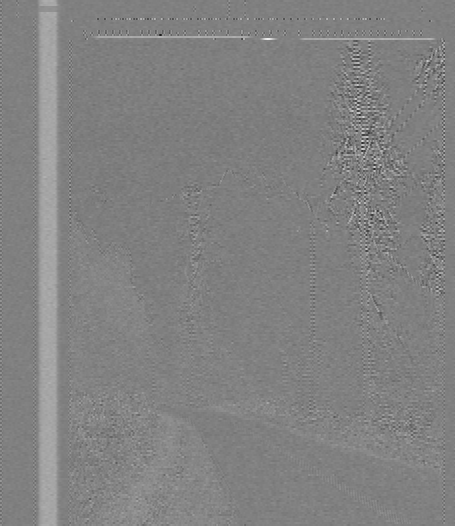

In [138]:
draw_raw_bwimage(c0.splitIQ(c0.cbuffer)[1] + 32768, 455, 263)

In [120]:
c0.splitIQ(c2.cbuffer)[0].shape

(119665,)

In [121]:
455*263

119665

In [32]:
c.cbuffer.size, cbuffera.size

(239330, 239330)

(237510,)
uint8 (261, 910) (261, 910)


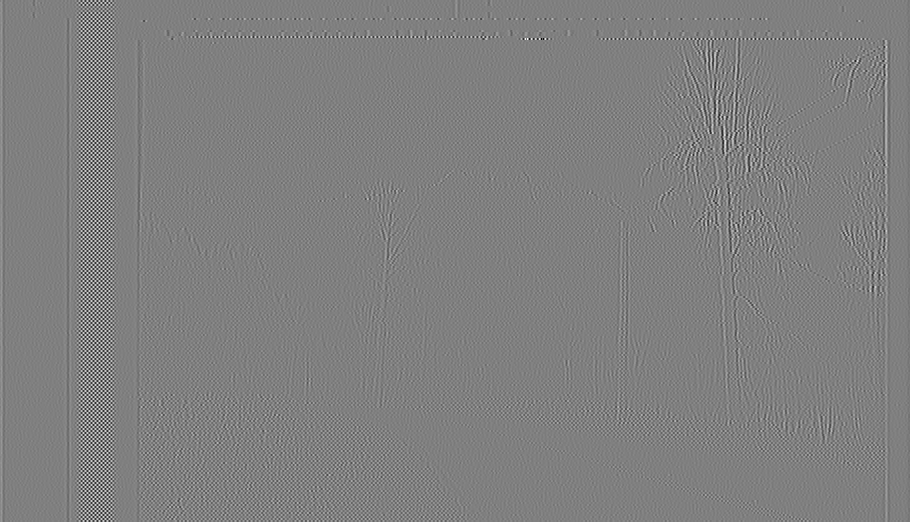

In [23]:
draw_raw_bwimage(np.diff(c2.cbuffer) + 32768, 910, 261)

In [ ]:
c2.cbuffer

(236600,)
uint8 (260, 910) (260, 910)


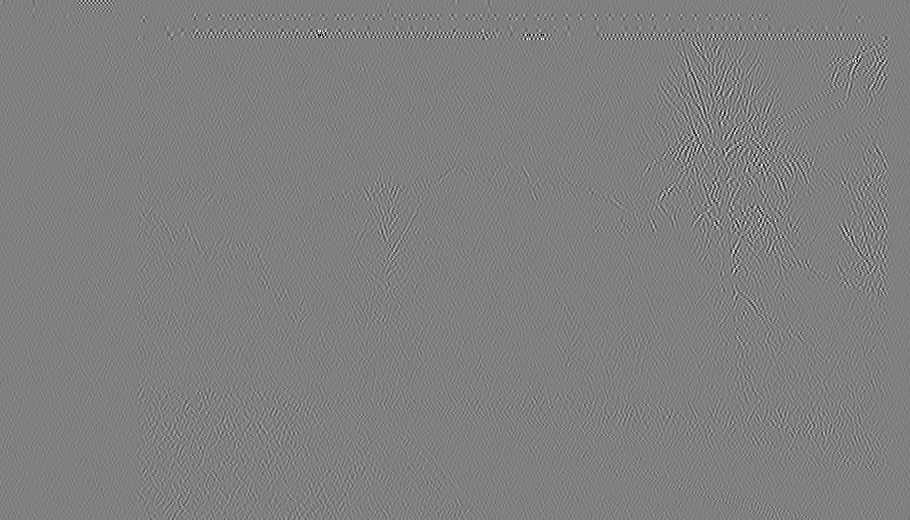

In [59]:
draw_raw_bwimage(np.diff(cbuffern2) + 32768, 910, 260)

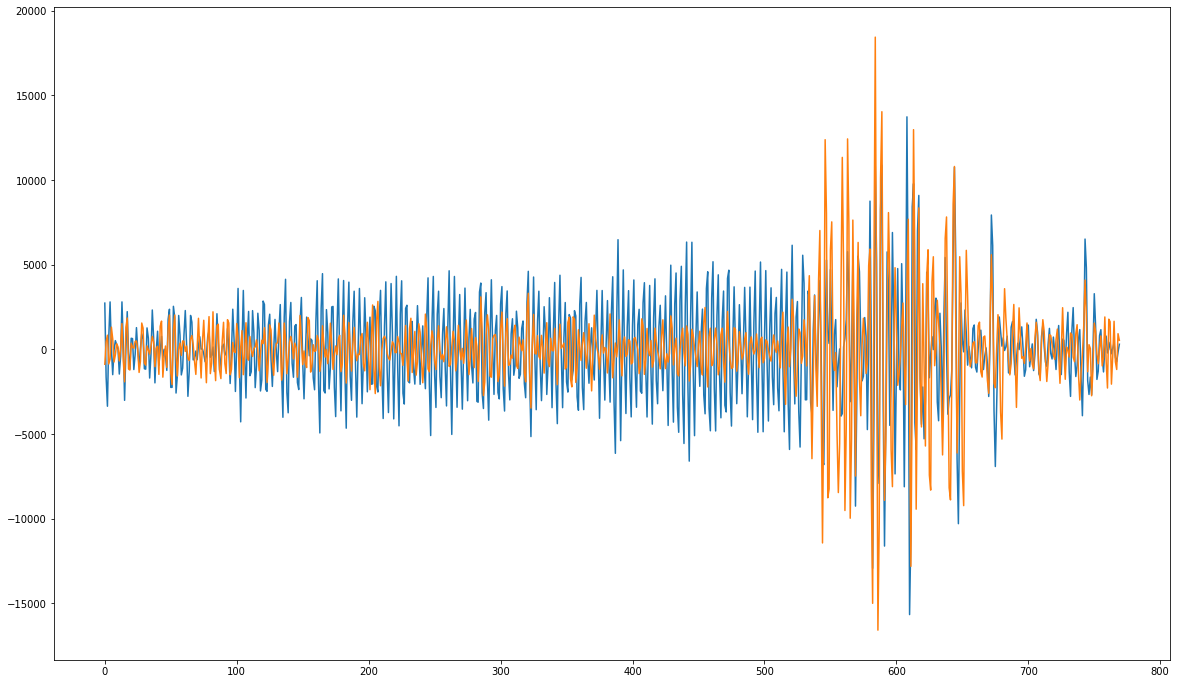

In [64]:
l = 60
ls = slice((910 * l)+140, 910 * (l + 1))
plt.plot(cbufferp1[ls])
plt.plot(cbufferp2[ls])

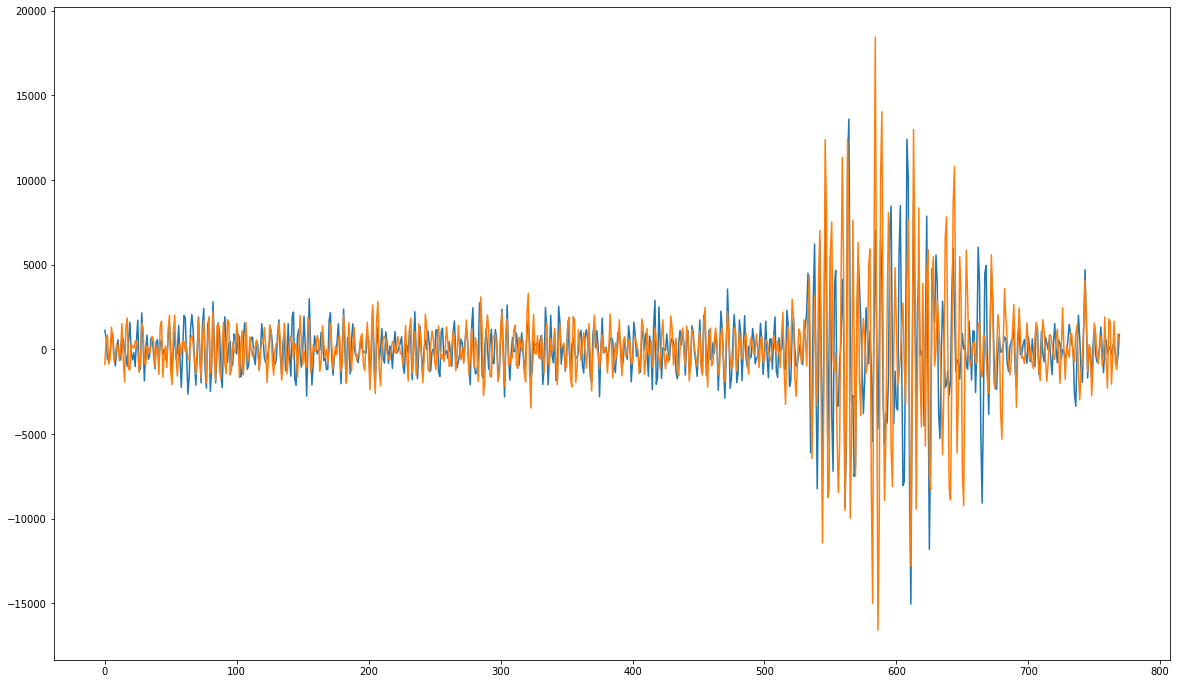

In [68]:
plt.plot(cbuffern2[ls])
plt.plot(cbufferp2[ls])

In [69]:
import scipy.signal as sps

In [74]:
ldd.rf.SysParams

{'fsc_mhz': 3.5795454545454546,
 'pilot_mhz': 3.5795454545454546,
 'frame_lines': 525,
 'field_lines': (263, 262),
 'ire0': 8100000,
 'hz_ire': 12142.857142857143,
 'vsync_ire': -40,
 'analog_audio': True,
 'audio_lfreq': 2301136.3636363638,
 'audio_rfreq': 2812500.0,
 'colorBurstUS': (5.3, 7.8),
 'activeVideoUS': (9.45, 62.05555555555555),
 'firstFieldH': (0.5, 1),
 'numPulses': 6,
 'hsyncPulseUS': 4.7,
 'eqPulseUS': 2.3,
 'vsyncPulseUS': 27.1,
 'line_period': 63.55555555555555,
 'FPS': 29.970029970029973,
 'outlinelen': 910,
 'outfreq': 14.318181818181818}

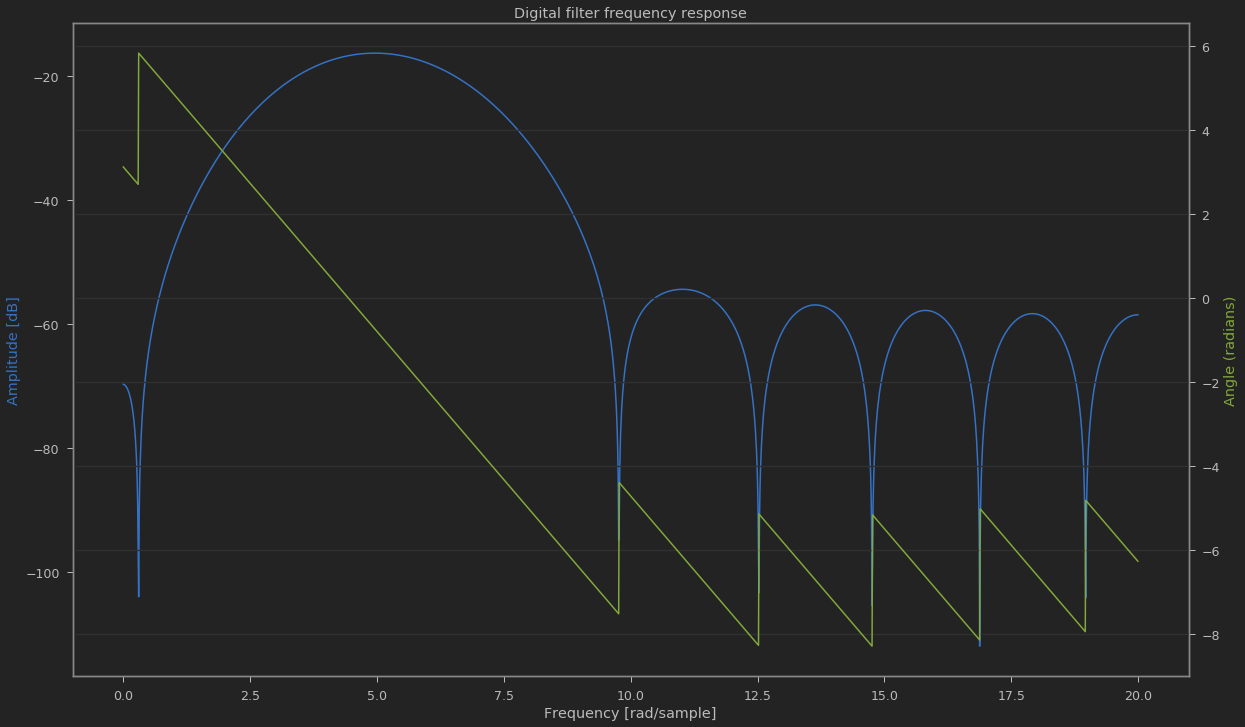

In [102]:
plotfilter(sps.firwin2(19, [0, .225, .24, .26, .275, 1], [0, 0, 1, 1, 0, 0]), [1.0])

In [103]:
B = sps.firwin2(17, [0, .225, .24, .26, .275, 1], [0, 0, 1, 1, 0, 0])
A = [1.0]

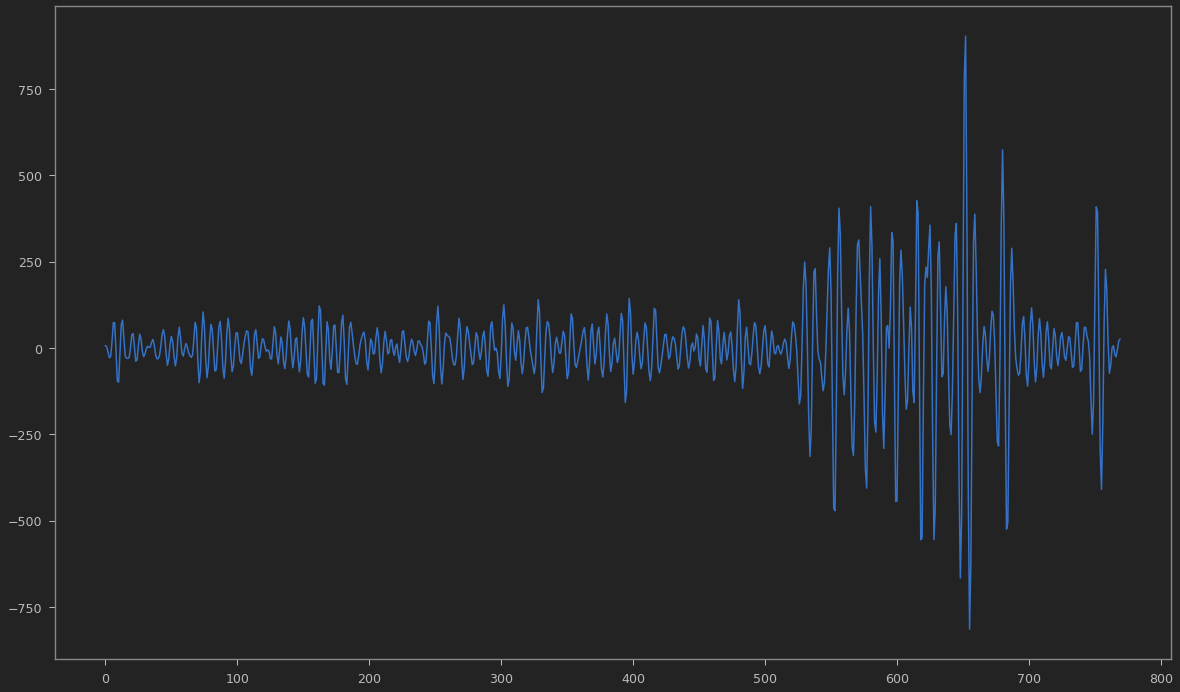

In [111]:
plt.plot(sps.lfilter(B, A, cbufferp1[ls]))

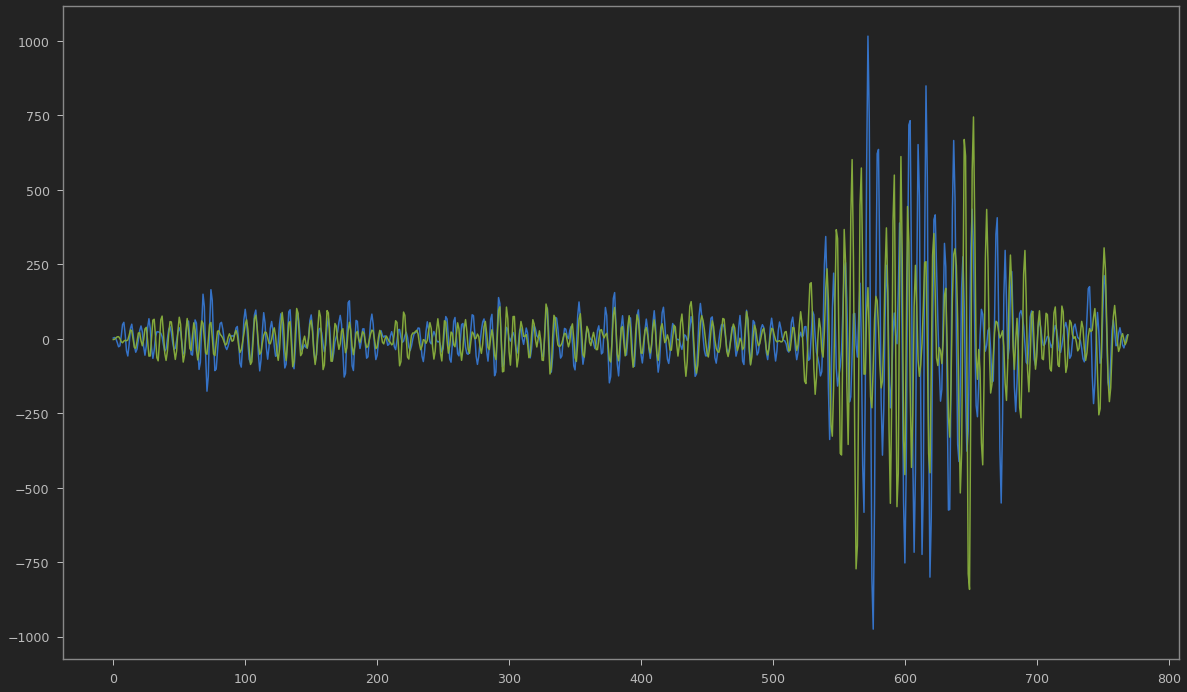

In [104]:
plt.plot(sps.lfilter(B, A, cbuffern2[ls]))
plt.plot(sps.lfilter(B, A, cbufferp2[ls]))

(236600,)
uint8 (260, 910) (260, 910)


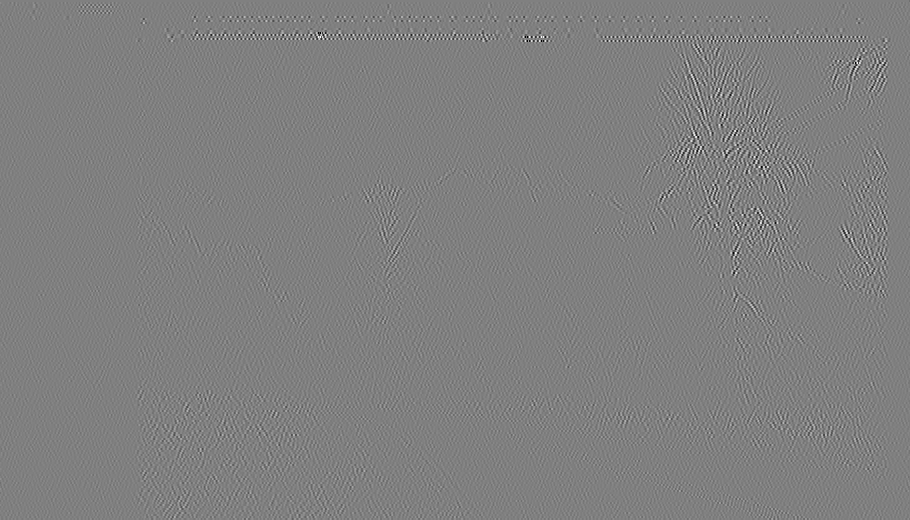

In [53]:
draw_raw_bwimage(np.diff(cbufferp - cbuffern) + 32768, 910, 260)

(237510,)
uint8 (261, 910) (261, 910)


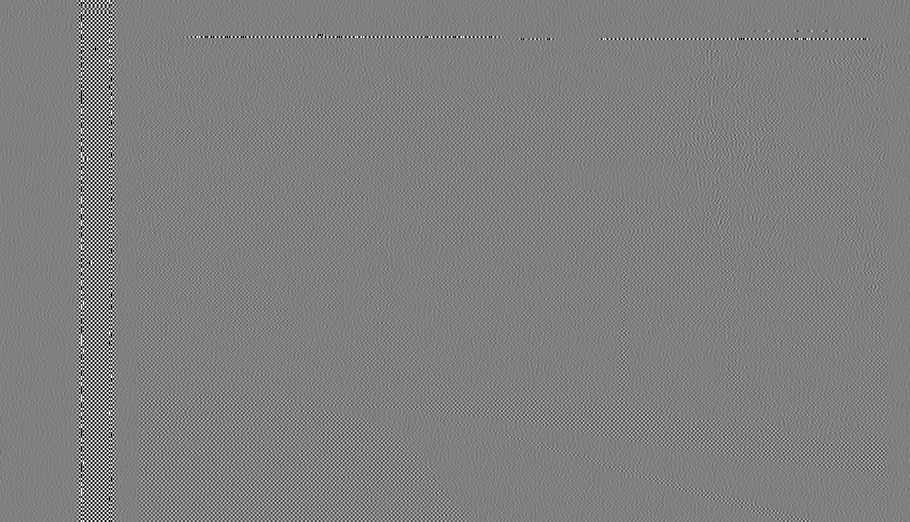

In [24]:
draw_raw_bwimage(np.diff(c0.cbuffer - c2.cbuffer) + 32768, 910, 261)